In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
PROJECT_PATH = '../'
DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [3]:
with h5py.File(PCA_PATH, 'r') as f:
    flux = f['flux'][()]
    flux_idx = f['flux_idx'][()]
#     Fe_H = f['Fe_H'][()]
#     log_g = f['log_g'][()]
#     O_M = f['O_M'][()]
#     C_M = f['C_M'][()]
#     T_eff = f['T_eff'][()]
    wave = f['wave'][()]
    eigv = f['flux_eigv'][()]
    eigs = f['flux_eigs'][()]    

In [4]:
flux.shape, eigv.shape, wave.shape, eigs.shape

((14, 66, 11, 6, 4, 1000), (15404, 1000), (15404,), (1000,))

In [5]:
flux0 = flux[flux_idx]

In [6]:
flux0.shape

(116614, 1000)

In [ ]:
# u, s, v = np.linalg.svd(flux0.T)

In [65]:
V = eigv **2 

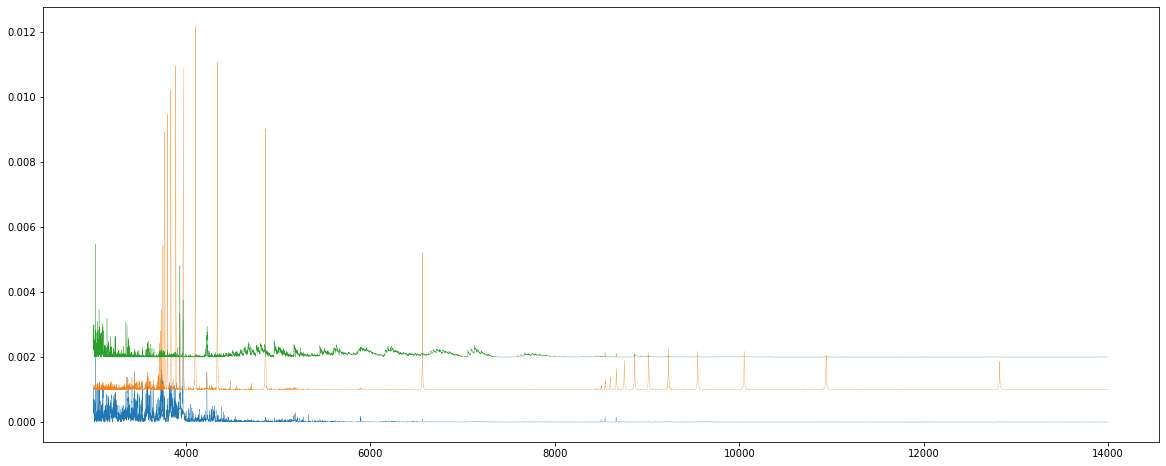

In [66]:
f, ax = plt.subplots(figsize=(20, 8))
ii = [0, 0.001, 0.002]
for i, k in enumerate([0, 1, 2]):
    ax.plot(wave, V[:, k] + ii[i], lw=0.3)
# ax.semilogy()

In [69]:
# LS = np.cumsum(V, axis = 1) / np.arange(1, len(eigv[0])+1)
LS.shape

(15404, 1000)

In [71]:
LS

array([[4.57941510e-04, 2.41155351e-04, 3.68600712e-04, ...,
        3.84765819e-04, 3.87236041e-04, 3.87079113e-04],
       [3.89313473e-04, 2.07272128e-04, 2.66161602e-04, ...,
        2.87458160e-04, 2.87616254e-04, 2.87346655e-04],
       [2.63198546e-04, 1.36702811e-04, 1.57269881e-04, ...,
        2.61795828e-04, 2.61555424e-04, 2.61587759e-04],
       ...,
       [1.11942722e-07, 6.46183338e-08, 1.40287987e-07, ...,
        5.09007638e-06, 5.08963361e-06, 5.08940599e-06],
       [3.38553471e-07, 1.69387975e-07, 1.46105978e-07, ...,
        7.21609379e-06, 7.22220879e-06, 7.22541398e-06],
       [1.31379151e-06, 6.60049737e-07, 4.86382584e-07, ...,
        2.20412185e-05, 2.21746267e-05, 2.21658498e-05]])

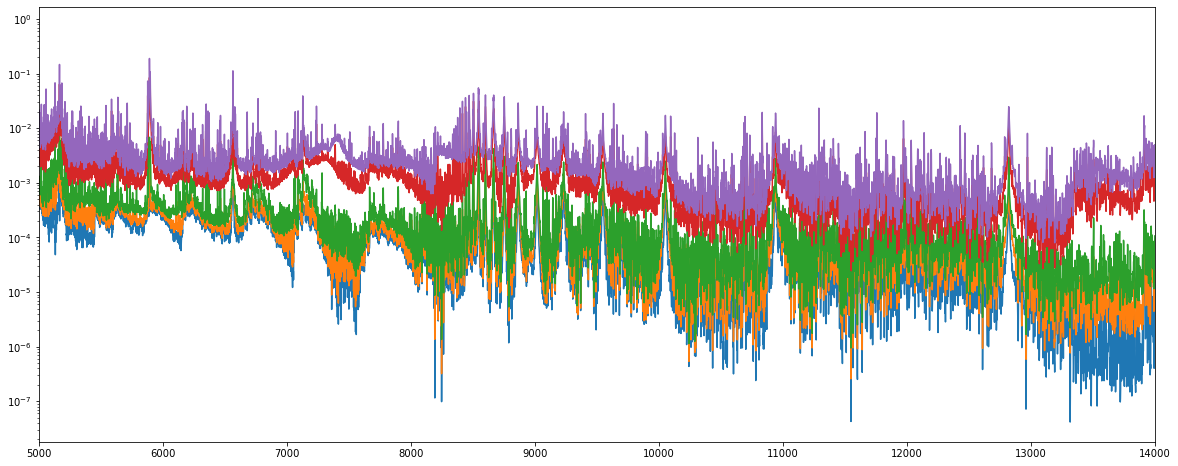

In [82]:
f, ax = plt.subplots(figsize=(20, 8))

LS1 = np.cumsum(V, axis = 1)
for k in [5, 10,20,100, 200]:
    plt.plot(wave, LS1[:,k])
plt.xlim(5000, 14000)
plt.yscale("log")
# plt.ylim(0., 0.0005)

In [22]:
np.digitize(5000, wave)

5108

In [75]:
LS0 = LS[5108:, :]

In [76]:
wave0 = wave[5108:]

In [77]:

pidx = np.argmax(LS0[:,200])

In [78]:
pidx

1640

In [27]:
pmax = LS0[2722, 200]

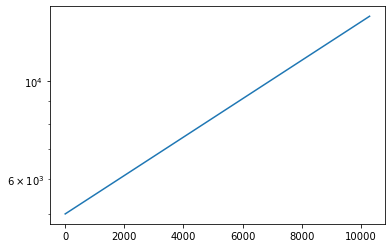

In [32]:
plt.plot(wave0)
# plt.xscale('log')
plt.yscale('log')

In [33]:
logwave= np.log(wave0)

In [34]:
logedge= 0.5 * (logwave[1:] + logwave[:-1])

In [35]:
logedge

array([8.5173047 , 8.51740474, 8.51750476, ..., 9.54650302, 9.54660301,
       9.54670302])

In [36]:
logwave

array([8.51725471, 8.5173547 , 8.51745478, ..., 9.54655302, 9.546653  ,
       9.54675304])

In [39]:
step = (logwave[1:] - logedge) [0]

In [40]:
step

4.999442466413484e-05

In [41]:
dlambda = wave0 / 5000 

In [42]:
dlambda

array([1.00006152, 1.00016152, 1.00026162, ..., 2.79927324, 2.79955312,
       2.7998332 ])

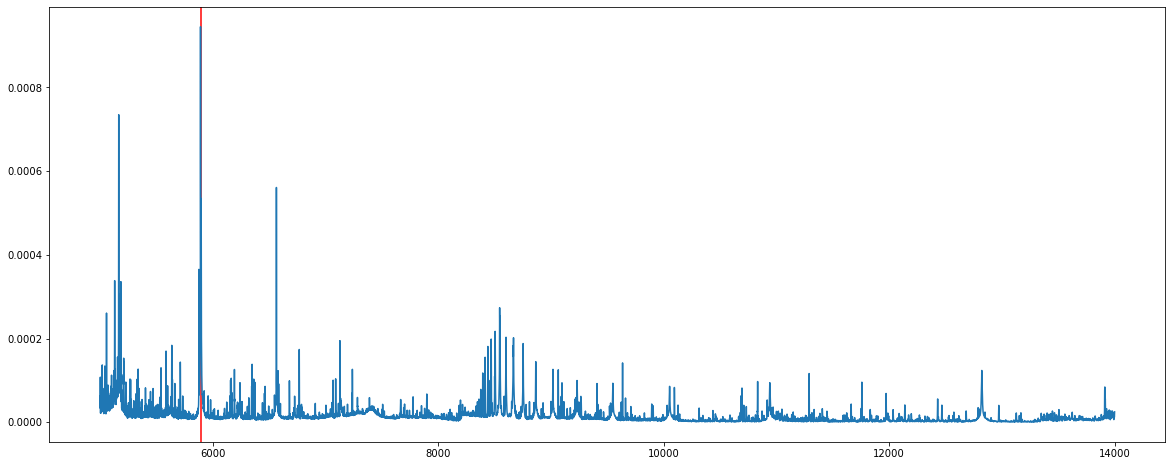

In [79]:
plt.figure(figsize=(20,8))
plt.axvline(wave0[pidx], c='r')
plt.plot(wave0, LS0[:,200])


In [59]:
dl = 0
dr = 1

In [60]:
lss = np.sum(LS0[(pidx-dl):(pidx+dr), 200])

In [61]:
lss

0.6438852538350787

In [ ]:
leverage

In [63]:
a = [1,2,3]

In [64]:
a[:2]

[1, 2]

In [119]:
np.inf

inf

In [120]:

class LeverageScore(object):
    def __init__(self, wave, eigv, k):
        
        self.k = k
        self.eigv = None
        self.lvrg = None
        self.wave = None
        self.wavebin = None
        self.wave_len = None
        self.pidxs = []
        self.init(wave, eigv, R=5000, wave_lb=5000)
        
    def init(self, wave, eigv, R, wave_lb):
        
        w_idx0 = np.digitize(wave_lb, wave)  
        
        self.wave = wave[w_idx0:]
        self.eigv = eigv[w_idx0:, :]
        self.wavebin = self.wave / R


        self.wave_len = len(self.wave)
        self.pc_len = len(self.eigv[0])
        
    def prepare(self):
        self.get_lvrg()
        pidx = self.get_max_p()
        self.plot_lvrg(pidx)
        return pidx
        
    def find_roi(self, pidx):
        dl, dr, info_gain = 0, 0, np.inf
        while info_gain > 0:
            dl, dr, info_gain = self.grow_roi(dl, dr)
            print(dl, dr)
#             break
        return dl, dr
        
        
    def get_lvrg(self):
        self.lvrg = np.cumsum(self.eigv**2, axis = 1) / np.arange(1, self.pc_len + 1)
        
    def get_max_p(self):
        pidx = np.argmax(self.lvrg[:, self.k])
        return pidx
    
    def get_info_gain(self, pidx, dl, dr):
        pidx_l = pidx - dl
        pidx_r = pidx + dr
        if pidx_l < 0 or pidx_r > self.wave_len:
            return 0, 0

        lvrg_sum = np.sum(self.lvrg[(pidx - dl):(pidx + dr), self.k])
        dl = np.sum(self.wavebin[(pidx - dl):(pidx + dr)])    
        info_gain = lvrg_sum / dl
        return lvrg_sum, dl, info_gain
    
    def grow_roi(self, dl, dr,):
        lvrg_sum_l, dl_l, info_gain_l = self.get_info_gain(pidx, dl=dl + 1, dr=dr)        
        lvrg_sum_r, dl_r, info_gain_r = self.get_info_gain(pidx, dl=dl, dr=dr + 1)
        
        if info_gain_l > info_gain_r:
            dl += 1
            lvrg_sum_new = lvrg_sum_l
            dl_new = dl_l
            info_gain_new = info_gain_l
            
        else:

            lvrg_sum_new = lvrg_sum_l
             info_gain_r
            
            
        return dl, dr, info_gain
    
    def get 
     lvrg_sum, dl, info_gain
    
    def plot_lvrg(self, pidx=None):
        f, ax = plt.subplots(figsize=(20, 8))
        if pidx is not None:
            plt.axvline(self.wave[pidx], color='r', label=f"Max P")
        plt.plot(self.wave, self.lvrg[:,self.k], color='k', label=f"Top-{self.k}")
        plt.xlim(self.wave[0], self.wave[-1])
        plt.yscale("log")
        plt.legend()
    
    
            

In [121]:
k = 200
ls = LeverageScore(wave, eigv, k)

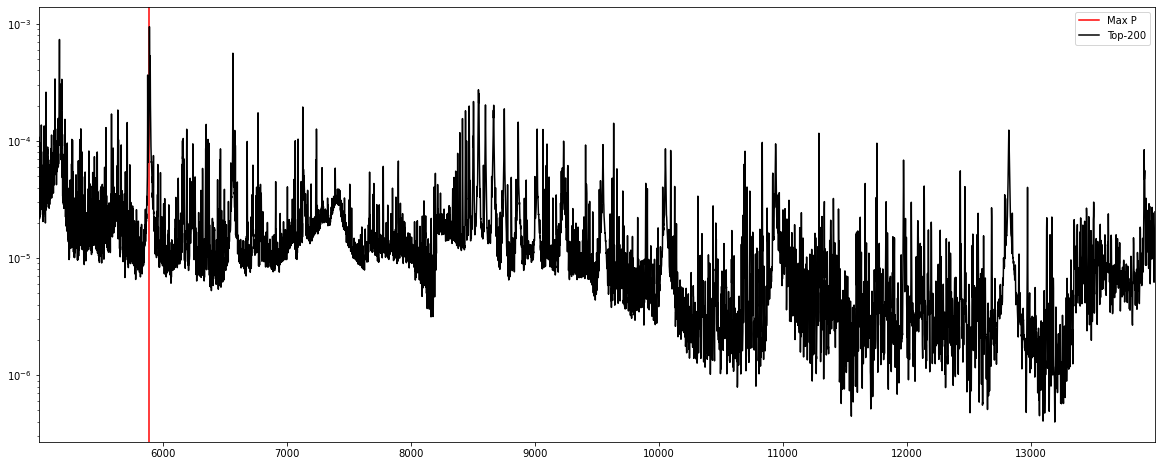

In [122]:
pidx = ls.prepare()

In [123]:
ls.run(pidx)

(0, 1)

In [62]:
def get_info_gain(pidx, lvrg, wavebin, k=200, dl=0, dr=0):
    lvrg_sum = np.sum(lvrg[(pidx - dl):(pidx + dr), k])
    dl = np.sum(wavebin[(pidx - dl):(pidx + dr)])    
    info_gain = lvrg_sum / dl
    return lvrg_sum, info_gain

In [ ]:
def grow_roi()

In [ ]:
while 

In [54]:
ddlambda = np.sum(dlambda[(pidx-5):(pidx+5)])

In [55]:
ddlambda

13.128641700000001

In [56]:
lss / ddlambda

0.04904431612564144

In [57]:
dlambda[pidx]

1.31292978

In [58]:
pidx

2722